In [2]:
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from cliff.api import Cliff
import seaborn as sns
from transformers import pipeline


# Data Preprocessing

## Dropping data with empty dates and sorting data by date

In [3]:
dataset = pd.read_json('random_reuters_c4.json').reset_index(drop = True)

In [4]:
dataset.head()

,text,timestamp,url
0,LONDON National Grid shares fell more than 3 p...,2019-04-18 23:15:16,https://uk.reuters.com/business/stocks/company...
1,"DENPASAR, Indonesia (Reuters) - A Russian man ...",2019-04-18 11:14:52,https://www.reuters.com/article/us-indonesia-o...
2,HONG KONG (Reuters) - A Chinese court has orde...,2019-04-18 17:52:25,https://www.reuters.com/article/us-samsung-ele...
3,NEW YORK (Reuters) - Index funds will grab mor...,2019-04-18 17:05:48,https://www.reuters.com/article/us-funds-passi...
4,NEW YORK (Reuters) - The U.S. Federal Reserve ...,2019-04-18 14:58:56,https://ca.reuters.com/article/businessNews/id...


In [5]:
dataset['timestamp']= pd.to_datetime(dataset['timestamp'])

## Predicting subject country of each article

In [6]:
# Execute the following from command-line first before running this cell
# docker pull rahulbot/cliff-clavin:latest
# docker run -p 8080:8080 -m 8G -d rahulbot/cliff-clavin:latest

my_cliff = Cliff('http://localhost:8080')
dataset["geoparsed"] = [my_cliff.parse_text(x) for x in tqdm(dataset["text"])]

100%|██████████| 90000/90000 [32:17<00:00, 46.46it/s]


## Cleaning dataset
- Extract out info from cliff-clavin output

In [7]:
cities_list, states_list, countries_list, country_name, country_code = [], [], [], [], []
for x in tqdm(dataset['geoparsed']):
    if x['results']['places']['focus']:
        cities_list.append(x['results']['places']['focus']['cities'])
        states_list.append(x['results']['places']['focus']['states'])
        countries_list.append(x['results']['places']['focus']['countries'])
        tmp_country_name, tmp_country_code = [], []
        for country in x['results']['places']['focus']['countries']:
            tmp_country_name.append(country['name'])
            tmp_country_code.append(country['countryCode'])
        country_name.append(tmp_country_name)
        country_code.append(tmp_country_code)
    else:
        cities_list.append(None)
        states_list.append(None)
        countries_list.append(None)
        country_name.append(None)
        country_code.append(None)

100%|██████████| 90000/90000 [00:00<00:00, 389881.70it/s]


In [8]:
dataset['cities_list'] = cities_list
dataset['states_list'] = states_list
dataset['countries_list'] = countries_list
dataset['country_name'] = country_name
dataset['country_code'] = country_code
dataset = dataset.drop(columns = 'geoparsed')

In [9]:
dataset.head()

,text,timestamp,url,cities_list,states_list,countries_list,country_name,country_code
0,LONDON National Grid shares fell more than 3 p...,2019-04-18 23:15:16,https://uk.reuters.com/business/stocks/company...,"[{'score': 3, 'featureCode': 'PPLC', 'stateGeo...","[{'score': 3, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 7, 'featureCode': 'PCLI', 'stateGeo...",[United Kingdom of Great Britain and Northern ...,[GB]
1,"DENPASAR, Indonesia (Reuters) - A Russian man ...",2019-04-18 11:14:52,https://www.reuters.com/article/us-indonesia-o...,"[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 3, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 8, 'featureCode': 'PCLI', 'stateGeo...",[Republic of Indonesia],[ID]
2,HONG KONG (Reuters) - A Chinese court has orde...,2019-04-18 17:52:25,https://www.reuters.com/article/us-samsung-ele...,"[{'score': 3, 'featureCode': 'PPLA2', 'stateGe...","[{'score': 3, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 8, 'featureCode': 'PCLI', 'stateGeo...",[People’s Republic of China],[CN]
3,NEW YORK (Reuters) - Index funds will grab mor...,2019-04-18 17:05:48,https://www.reuters.com/article/us-funds-passi...,[],"[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 5, 'featureCode': 'PCLI', 'stateGeo...",[United States],[US]
4,NEW YORK (Reuters) - The U.S. Federal Reserve ...,2019-04-18 14:58:56,https://ca.reuters.com/article/businessNews/id...,"[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 5, 'featureCode': 'PCLI', 'stateGeo...",[United States],[US]


# Extract out countries

In [10]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

In [11]:
# Check for number of rows with no countries assosociated: 68043 rows
no_country = dataset['countries_list'].isnull().sum()
old_rows = dataset.shape[0]
print("Number of articles with no countries detected: {}".format(no_country))
print("Percentage of articles with no countries detected: {:.2f}%".format(no_country/old_rows * 100))

Number of articles with no countries detected: 4860
Percentage of articles with no countries detected: 5.40%


In [12]:
# Drop rows with no country tagged; make sure no data lost
dataset = dataset.dropna(axis = 0, subset = ['countries_list'])
print(dataset.shape[0] == old_rows - no_country)
print("Number of articles left with countries detected: {}".format(dataset.shape[0]))

True
Number of articles left with countries detected: 85140


Text(0.5, 1.0, 'Distribution of articles with focus country')

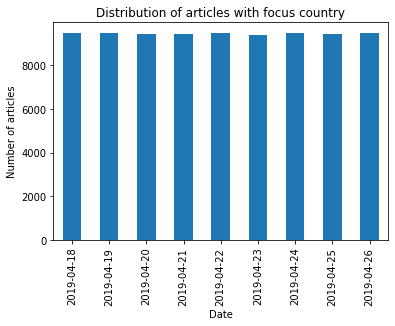

In [13]:
dataset['timestamp'].dt.date.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Date')
plt.ylabel('Number of articles')
plt.title('Distribution of articles with focus country')

In [14]:
# For rows with more than 1 country, duplicate them such that each row only contains one country
dataset.rename(columns={'country_name': 'x', 'country_code': 'y'}, inplace=True)
dataset = dataset.explode(list('xy'))
dataset.rename(columns={'x': 'country_name', 'y': 'country_code'}, inplace=True)
dataset.tail()

,text,timestamp,url,cities_list,states_list,countries_list,country_name,country_code
89996,March 25 (Reuters) - Reaction after Australia’...,2019-04-26 02:50:35,https://uk.reuters.com/article/cricket-test-za...,[],[],"[{'score': 2, 'featureCode': 'PCLI', 'stateGeo...",Republic of South Africa,ZA
89996,March 25 (Reuters) - Reaction after Australia’...,2019-04-26 02:50:35,https://uk.reuters.com/article/cricket-test-za...,[],[],"[{'score': 2, 'featureCode': 'PCLI', 'stateGeo...",Commonwealth of Australia,AU
89997,Greek Prime Minister Alexis Tsipras wins a com...,2019-04-26 16:22:29,https://uk.mobile.reuters.com/video/2015/07/08...,"[{'score': 2, 'featureCode': 'PPLC', 'stateGeo...","[{'score': 2, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 6, 'featureCode': 'PCLI', 'stateGeo...",Hellenic Republic,GR
89998,NEW YORK (Reuters) - Johnson & Johnson (JNJ.N)...,2019-04-26 01:07:23,https://in.reuters.com/article/us-johnson-john...,"[{'score': 1, 'featureCode': 'PPLA2', 'stateGe...","[{'score': 2, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 6, 'featureCode': 'PCLI', 'stateGeo...",United States,US
89999,(Reuters Health) - As much as children need li...,2019-04-26 10:22:49,https://uk.reuters.com/article/us-health-paren...,"[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",United States,US


In [15]:
country_count = dataset['country_code'].value_counts(dropna=False)
country_count.to_json('C4 Reuters News Total Country Counts.json')

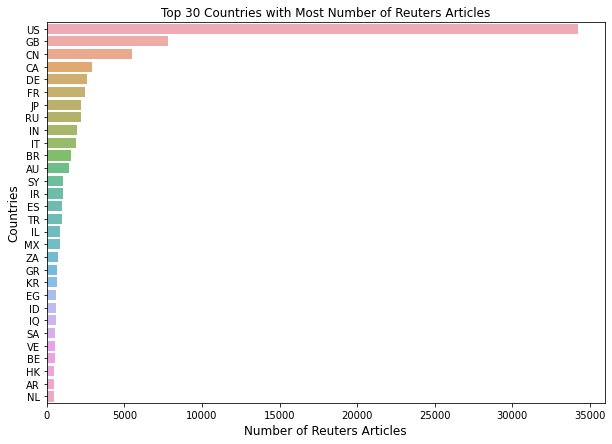

In [16]:
country_count = country_count[:30,]
plt.figure(figsize=(10,7))
sns.barplot(y = country_count.index, x= country_count.values, alpha=0.8)
plt.title('Top 30 Countries with Most Number of Reuters Articles')
plt.xlabel('Number of Reuters Articles', fontsize=12)
plt.ylabel('Countries', fontsize=12)
# plt.grid()
plt.show()

In [21]:
dataset = dataset.reset_index(drop =True)

In [22]:
dataset.to_json('c4_reuters_geoparsed.json')

# Splitting into buckets for countries of interest

In [23]:
countries_of_interest = ['US', 'GB', 'JP', 'IN', 'CN',  'ID', 'LA', 'MM', 'BN', 'KH', 'TL', 'MY', 'SG', 'PH', 'TH', 'VN' ]

for country in countries_of_interest:
    tmp = dataset[dataset['country_code'] == country]
    tmp.to_json('c4_reuters_' + country+ '.json')
    print("Total number of articles for {}: {}".format(country, tmp.shape[0]))


Total number of articles for US: 34241
Total number of articles for GB: 7786
Total number of articles for JP: 2223
Total number of articles for IN: 1978
Total number of articles for CN: 5480
Total number of articles for ID: 581
Total number of articles for LA: 17
Total number of articles for MM: 263
Total number of articles for BN: 8
Total number of articles for KH: 81
Total number of articles for TL: 10
Total number of articles for MY: 330
Total number of articles for SG: 444
Total number of articles for PH: 301
Total number of articles for TH: 349
Total number of articles for VN: 195
